In [1]:
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import shap

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso

import datetime
import time

c:\Users\hoang\.conda\envs\min_ds-env\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
c:\Users\hoang\.conda\envs\min_ds-env\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(al

### NHANES - MORT (3.2. Explaining a feature not used by the model)

In [2]:
nhanes = pd.read_csv('data/nhanes/nhanes_raw.csv',
                    low_memory=False, index_col=0)
nhanes

,ID,SurveyYr,Gender,Age,AgeMonths,Race1,Race3,Education,MaritalStatus,HHIncome,...,SexAge,SexNumPartnLife,SexNumPartYear,SameSex,SexOrientation,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,PregnantNow
1,51624,2009_10,male,34,409.0,White,NaN,High School,Married,25000-34999,...,16.0,8.0,1.0,No,Heterosexual,80100.543510,81528.772010,1,83,NaN
2,51625,2009_10,male,4,49.0,Other,NaN,NaN,NaN,20000-24999,...,NaN,NaN,NaN,NaN,NaN,53901.104290,56995.035430,2,79,NaN
3,51626,2009_10,male,16,202.0,Black,NaN,NaN,NaN,45000-54999,...,NaN,NaN,NaN,NaN,NaN,13953.078340,14509.278860,1,84,NaN
4,51627,2009_10,male,10,131.0,Black,NaN,NaN,NaN,20000-24999,...,NaN,NaN,NaN,NaN,NaN,11664.899400,12041.635370,2,86,NaN
5,51628,2009_10,female,60,722.0,Black,NaN,High School,Widowed,10000-14999,...,15.0,4.0,NaN,No,NaN,20090.339260,21000.338720,2,75,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20289,71912,2011_12,male,40,NaN,White,White,8th Grade,Married,25000-34999,...,14.0,15.0,15.0,No,Heterosexual,19633.637050,20770.138120,1,98,NaN
20290,71913,2011_12,female,18,NaN,Other,Asian,NaN,NaN,75000-99999,...,NaN,0.0,0.0,No,Heterosexual,7382.152016,8028.485773,1,94,NaN
20291,71914,2011_12,female,10,NaN,White,White,NaN,NaN,75000-99999,...,NaN,NaN,NaN,NaN,NaN,60197.256540,63931.531990,2,94,NaN
20292,71915,2011_12,male,60,NaN,White,White,College Grad,NeverMarried,65000-74999,...,19.0,2.0,NaN,No,NaN,88961.259220,91446.591980,3,90,NaN


#### 2009 mortality data

In [3]:
mort09 = pd.read_csv('data/nhanes/mort_nhanes_2009_2010.csv',
                    low_memory=False, index_col=0)
mort09 = mort09.rename(columns={'seqn': 'ID'})
mort09.head()

,ID,eligstat,mortstat,ucod_leading,diabetes,hyperten,permth_int,permth_exm
1,51624,1,0.0,NaN,NaN,NaN,111.0,111.0
2,51625,2,NaN,NaN,NaN,NaN,NaN,NaN
3,51626,2,NaN,NaN,NaN,NaN,NaN,NaN
4,51627,2,NaN,NaN,NaN,NaN,NaN,NaN
5,51628,1,0.0,NaN,NaN,NaN,133.0,132.0


#### 2010 mortality data

In [4]:
mort11 = pd.read_csv('data/nhanes/mort_nhanes_2011_2012.csv',
                    low_memory=False, index_col=0)
mort11 = mort11.rename(columns={'seqn': 'ID'})
mort11.head()

,ID,eligstat,mortstat,ucod_leading,diabetes,hyperten,permth_int,permth_exm
1,62161,1,0.0,NaN,NaN,NaN,93.0,92.0
2,62162,2,NaN,NaN,NaN,NaN,NaN,NaN
3,62163,2,NaN,NaN,NaN,NaN,NaN,NaN
4,62164,1,0.0,NaN,NaN,NaN,90.0,89.0
5,62165,2,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
mort = pd.concat([mort09, mort11], axis=0)
mort.head()

,ID,eligstat,mortstat,ucod_leading,diabetes,hyperten,permth_int,permth_exm
1,51624,1,0.0,NaN,NaN,NaN,111.0,111.0
2,51625,2,NaN,NaN,NaN,NaN,NaN,NaN
3,51626,2,NaN,NaN,NaN,NaN,NaN,NaN
4,51627,2,NaN,NaN,NaN,NaN,NaN,NaN
5,51628,1,0.0,NaN,NaN,NaN,133.0,132.0


In [6]:
nhanes=nhanes.merge(mort, on='ID', how='outer')
# rm rows with Survey Year NaN
nhanes=nhanes[~nhanes['SurveyYr'].isna()]
# rm rows with Mortality Status NaN
nhanes=nhanes[~nhanes['mortstat'].isna()]
nhanes

,ID,SurveyYr,Gender,Age,AgeMonths,Race1,Race3,Education,MaritalStatus,HHIncome,...,SDMVPSU,SDMVSTRA,PregnantNow,eligstat,mortstat,ucod_leading,diabetes,hyperten,permth_int,permth_exm
0,51624,2009_10,male,34,409.0,White,NaN,High School,Married,25000-34999,...,1,83,NaN,1,0.0,NaN,NaN,NaN,111.0,111.0
4,51628,2009_10,female,60,722.0,Black,NaN,High School,Widowed,10000-14999,...,2,75,NaN,1,0.0,NaN,NaN,NaN,133.0,132.0
5,51629,2009_10,male,26,313.0,Mexican,NaN,9 - 11th Grade,Married,25000-34999,...,1,88,NaN,1,0.0,NaN,NaN,NaN,112.0,112.0
6,51630,2009_10,female,49,596.0,White,NaN,Some College,LivePartner,35000-44999,...,2,85,NaN,1,0.0,NaN,NaN,NaN,109.0,109.0
9,51633,2009_10,male,80,NaN,White,NaN,Some College,Married,15000-19999,...,1,77,NaN,1,0.0,NaN,NaN,NaN,124.0,123.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20285,71909,2011_12,male,28,NaN,Mexican,Mexican,9 - 11th Grade,NeverMarried,5000-9999,...,2,103,NaN,1,0.0,NaN,NaN,NaN,86.0,85.0
20287,71911,2011_12,male,27,NaN,Mexican,Mexican,College Grad,Married,75000-99999,...,2,102,NaN,1,0.0,NaN,NaN,NaN,97.0,96.0
20288,71912,2011_12,male,40,NaN,White,White,8th Grade,Married,25000-34999,...,1,98,NaN,1,0.0,NaN,NaN,NaN,95.0,95.0
20289,71913,2011_12,female,18,NaN,Other,Asian,NaN,NaN,75000-99999,...,1,94,NaN,1,0.0,NaN,NaN,NaN,91.0,90.0


In [7]:
ft_train= ['Age', 'BMI', 'HHIncomeMid', 'BPSysAve', 'Pulse']
ft_target = ['mortstat']
nhanes_ = nhanes[ft_train + ft_target]
nhanes_ = nhanes_.dropna()
nhanes_

,Age,BMI,HHIncomeMid,BPSysAve,Pulse,mortstat
0,34,32.22,30000.0,113.0,70.0,0.0
4,60,42.39,12500.0,150.0,72.0,0.0
5,26,32.61,30000.0,104.0,72.0,0.0
6,49,30.57,40000.0,112.0,86.0,0.0
9,80,26.04,17500.0,139.0,88.0,0.0
...,...,...,...,...,...,...
20285,28,29.40,7500.0,124.0,68.0,0.0
20287,27,31.30,87500.0,133.0,74.0,0.0
20288,40,27.90,30000.0,120.0,112.0,0.0
20289,18,21.60,87500.0,108.0,92.0,0.0


In [8]:
# split data into train and test sets
X = nhanes_.drop('mortstat', axis=1)
y = nhanes_['mortstat']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

#### Train a logistic regression model to predict mortality using 4 features

In [9]:
logreg = LogisticRegression(max_iter=100000, n_jobs=-1)

logreg.fit(X_train.drop('BMI', axis=1), y_train)
y_pred = logreg.predict(X_test.drop('BMI', axis=1))
print('- Accuracy of logistic regression classifier on test set: {:.4f}'\
    .format(accuracy_score(y_test, y_pred)))

- Accuracy of logistic regression classifier on test set: 0.8928


#### Interventional - 4 features (BMI excluded)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


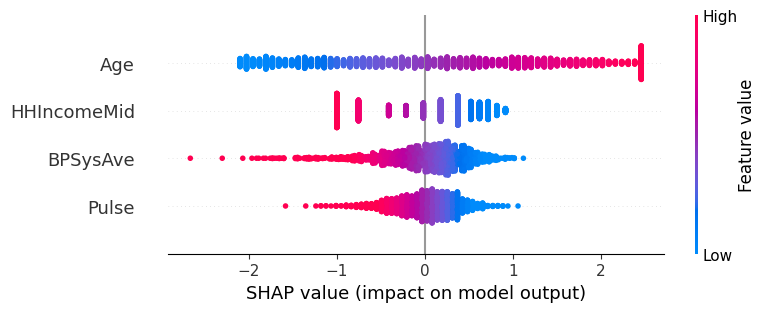

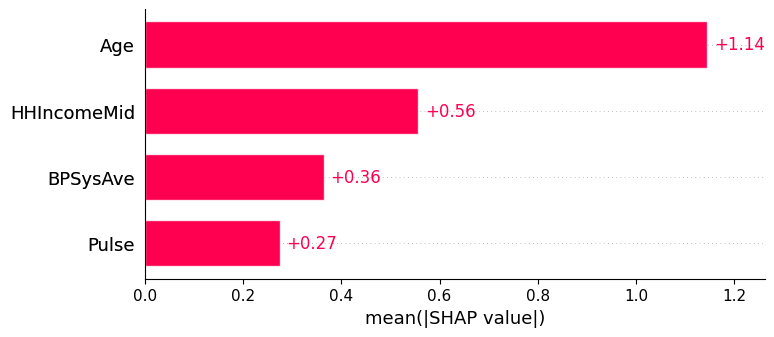

In [10]:
masker = shap.maskers.Independent(X_train.drop('BMI', axis=1))
explainer = shap.Explainer(logreg, masker)
shap_values = explainer(X_test.drop('BMI', axis=1))
shap.plots.beeswarm(shap_values)
shap.plots.bar(shap_values)

#### Observational - 4 features (BMI excluded)

Estimating transforms: 100%|██████████| 1000/1000 [00:00<00:00, 4610.69it/s]
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


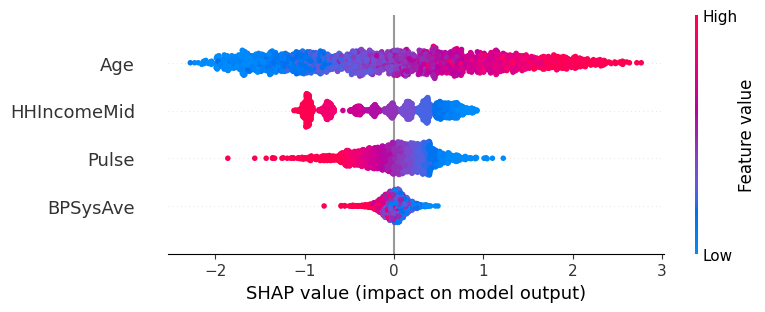

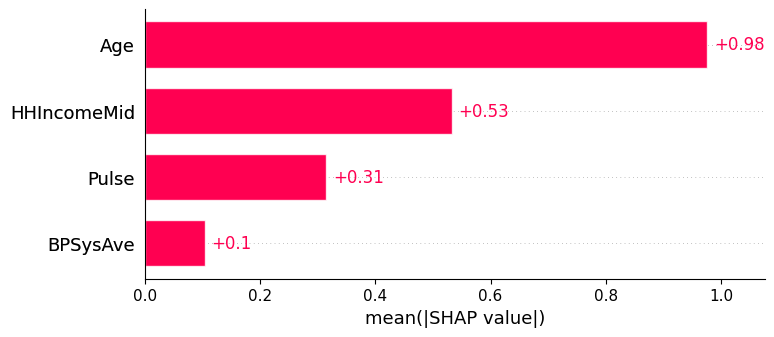

In [11]:
masker = shap.maskers.Impute(X_train.drop('BMI', axis=1))
explainer = shap.Explainer(logreg, masker, algorithm='linear')
shap_values = explainer(X_test.drop('BMI', axis=1))
shap.plots.beeswarm(shap_values)
shap.plots.bar(shap_values)

#### Observational - 5 features

In [12]:
logreg = LogisticRegression(max_iter=100000, n_jobs=-1)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('- Accuracy of logistic regression classifier on test set: {:.4f}'\
    .format(accuracy_score(y_test, y_pred)))

- Accuracy of logistic regression classifier on test set: 0.8928


Estimating transforms: 100%|██████████| 1000/1000 [00:00<00:00, 2394.01it/s]
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


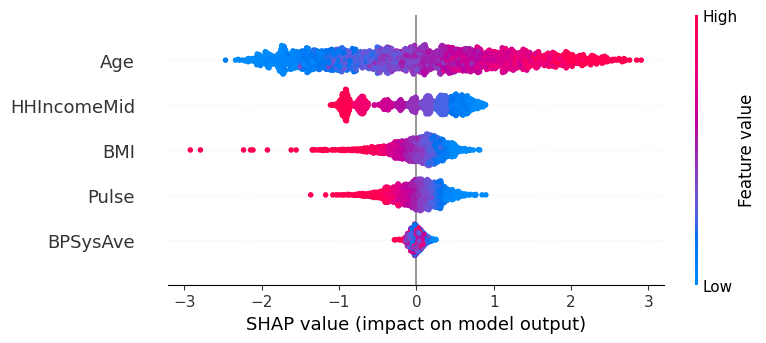

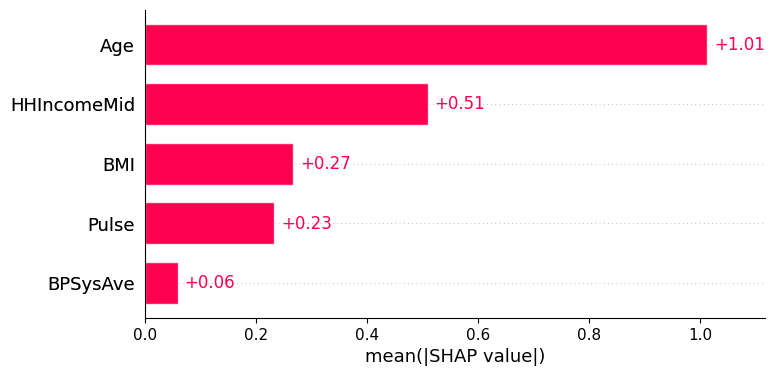

In [13]:
masker = shap.maskers.Impute(X_train)
explainer = shap.Explainer(logreg, masker, algorithm='linear')
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)
shap.plots.bar(shap_values)

### Lending club (4.1. True to the Model)

### Preprocess

In [14]:
lclub=pd.read_csv('data/lendingclub/lendingclub.csv', low_memory=False)

In [15]:
# drop id
lclub.drop('id', axis=1, inplace=True)

In [16]:
# drop column with more than 1000 missing values
lclub.dropna(axis=1, thresh=int((1-(1000/lclub.shape[0]))*len(lclub)), inplace=True)

In [17]:
# every column that is categorical

lclub.select_dtypes(include=['object']).columns

Index(['issue_d', 'grade', 'sub_grade', 'addr_state', 'grade.1', 'purpose',
       'term', 'zip_code'],
      dtype='object')

In [18]:
# drop grades, addr_state
lclub.drop(['grade', 'sub_grade', 'grade.1', 'addr_state'], axis=1, inplace=True)

In [19]:
lclub.issue_d = pd.to_datetime(lclub.issue_d)

# lclub['issue_d_year'] = lclub.issue_d.dt.year # same year
lclub['issue_d_month'] = lclub.issue_d.dt.month

lclub.drop(['issue_d'], axis=1, inplace=True)

lclub.select_dtypes(include=['object']).columns

Index(['purpose', 'term', 'zip_code'], dtype='object')

In [20]:
# fill nan with mean
lclub.fillna(lclub.mean(numeric_only=True), inplace=True)

In [21]:
# remove months
lclub.term = lclub.term.str.extract('(\d+)').astype(int)

In [22]:
lclub.select_dtypes(include=['object']).columns

Index(['purpose', 'zip_code'], dtype='object')

In [23]:
# drop zip_code
lclub.drop(['zip_code'], axis=1, inplace=True)

In [24]:
# dummy variables
lclub = pd.get_dummies(lclub, columns=['purpose'], drop_first=True)

#### Calculate log odds/log odds difference after modifying the feature

In [25]:
# train test split
X = lclub.drop('loan_status', axis=1)
y = lclub['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

logreg = LogisticRegression(max_iter=100000, n_jobs=-1)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('- Accuracy of logistic regression classifier on test set: {:.4f}'\
    .format(accuracy_score(y_test, y_pred)))

- Accuracy of logistic regression classifier on test set: 0.7351


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


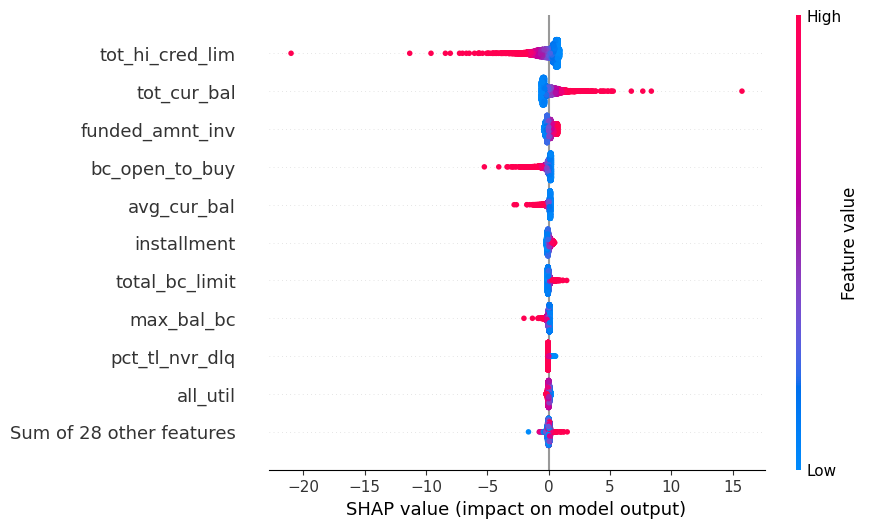

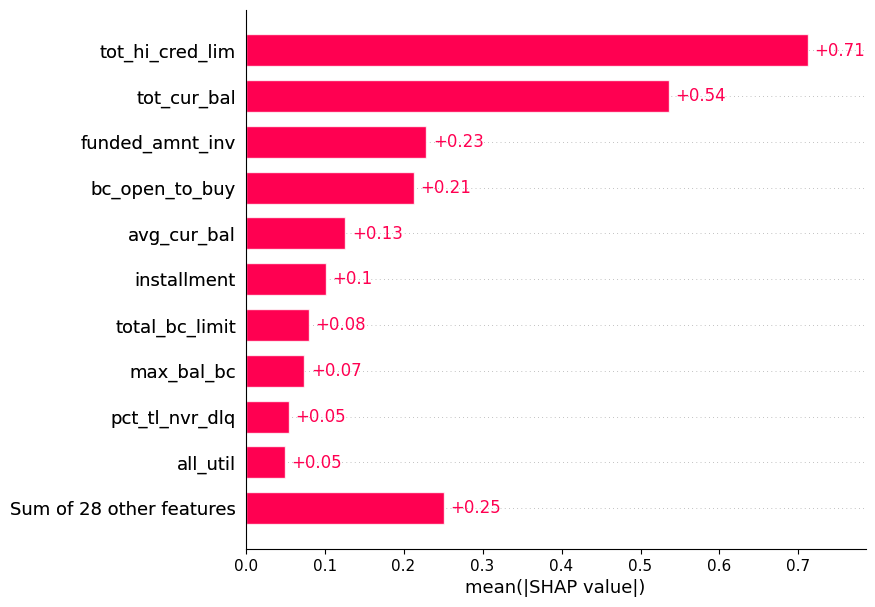

In [26]:
# shapley
masker = shap.maskers.Independent(X_train)
explainer = shap.LinearExplainer(logreg, masker)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values, max_display=11)
shap.plots.bar(shap_values, max_display=11)

In [27]:
# top 10 features
ft_id=np.argsort(np.mean(np.abs(shap_values.values), axis=0))[::-1][:10]
top10_ft_i=X_test.columns[ft_id]
top10_ft_i

Index(['tot_hi_cred_lim', 'tot_cur_bal', 'funded_amnt_inv', 'bc_open_to_buy',
       'avg_cur_bal', 'installment', 'total_bc_limit', 'max_bal_bc',
       'pct_tl_nvr_dlq', 'all_util'],
      dtype='object')

In [28]:
# 0: max -> how we should modify the feature to achieve the prediction of 1
# 1: min
ft_i_dict=[0, 1, 1, 0, 0, 1, 1, 0, 0, 0]
ft_i_dict=dict(zip(top10_ft_i, ft_i_dict))
ft_i_dict

{'tot_hi_cred_lim': 0,
 'tot_cur_bal': 1,
 'funded_amnt_inv': 1,
 'bc_open_to_buy': 0,
 'avg_cur_bal': 0,
 'installment': 1,
 'total_bc_limit': 1,
 'max_bal_bc': 0,
 'pct_tl_nvr_dlq': 0,
 'all_util': 0}

Estimating transforms: 100%|██████████| 1000/1000 [00:02<00:00, 380.62it/s]
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


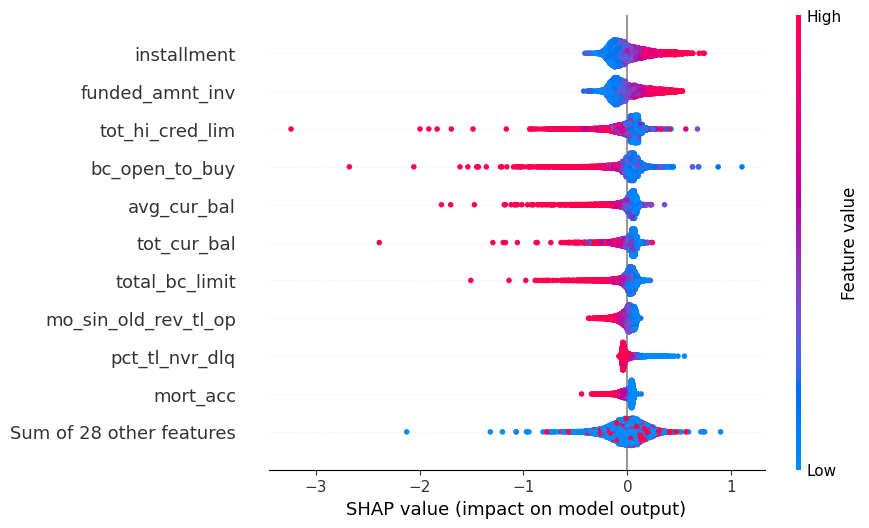

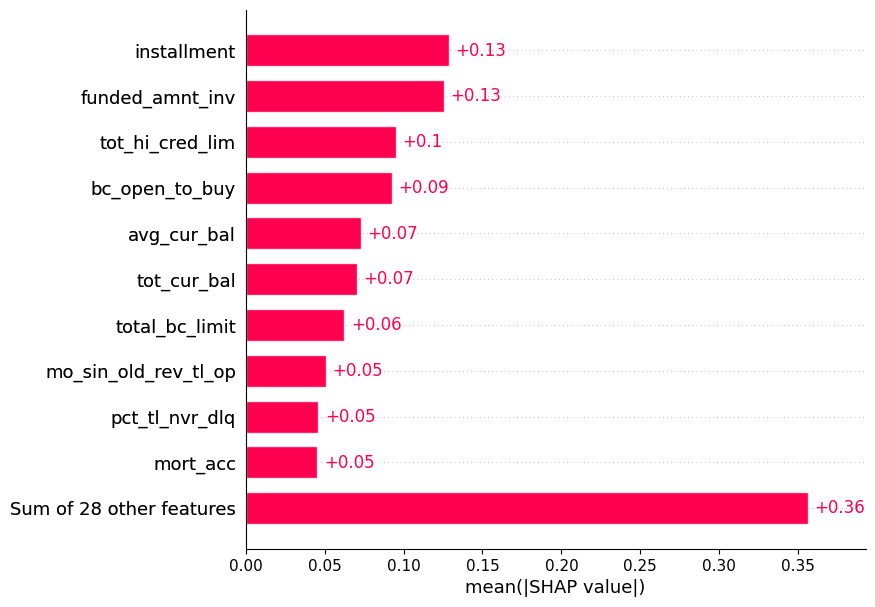

In [29]:
# observational
masker = shap.maskers.Impute(X_train)
explainer = shap.LinearExplainer(logreg, masker)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values, max_display=11)
shap.plots.bar(shap_values, max_display=11)

In [30]:
# top 10 features
ft_id=np.argsort(np.mean(np.abs(shap_values.values), axis=0))[::-1][:10]
top10_ft_c=X_test.columns[ft_id]
top10_ft_c

Index(['installment', 'funded_amnt_inv', 'tot_hi_cred_lim', 'bc_open_to_buy',
       'avg_cur_bal', 'tot_cur_bal', 'total_bc_limit', 'mo_sin_old_rev_tl_op',
       'pct_tl_nvr_dlq', 'mort_acc'],
      dtype='object')

In [31]:
# 0: max -> how we should modify the feature to achieve the prediction of 1
# 1: min
ft_c_modify = [1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
ft_c_dict=dict(zip(top10_ft_c, ft_c_modify))
ft_c_dict

{'installment': 1,
 'funded_amnt_inv': 1,
 'tot_hi_cred_lim': 0,
 'bc_open_to_buy': 0,
 'avg_cur_bal': 0,
 'tot_cur_bal': 0,
 'total_bc_limit': 0,
 'mo_sin_old_rev_tl_op': 0,
 'pct_tl_nvr_dlq': 0,
 'mort_acc': 0}

In [32]:
def logodds_default(X_test, logreg, top10_ft_dict, diff=True):
    X_test_modified = X_test.copy()
    yp=logreg.predict(X_test)
    logodds_list = [np.log((len(yp[yp == 0])+1)/len(yp[yp == 1]+1))]

    for feature in top10_ft_dict.keys():
        if top10_ft_dict[feature] == 0:
            X_test_modified[feature] = X_test[feature].min()
        else:
            X_test_modified[feature] = X_test[feature].max()
        
        y_pred = logreg.predict(X_test_modified)
        notdefault = y_pred[y_pred == 1]
        default = y_pred[y_pred == 0]
        logodds = np.log((len(default)+1)/(len(notdefault)+1))
        logodds_list.append(logodds)

        print(f'0/1: {len(default)} / {len(notdefault)} -> logodds: {logodds}')

    print('-----------------')
    
    if diff:
        logodds_diff = []
        for i in range(len(logodds_list)):
            logodds_diff.append(logodds_list[i] - logodds_list[i-1])

        logodds_diff[0] = 0
        logodds_diff

        return logodds_list, logodds_diff

    else:
        return logodds_list

In [33]:
print('1: Not default, 0: Default')
print('-----------------')
logodds_c, logodds_diff_c = logodds_default(X_test, logreg, ft_c_dict)
logodds_i, logodds_diff_i = logodds_default(X_test, logreg, ft_i_dict)

1: Not default, 0: Default
-----------------
0/1: 5958 / 396 -> logodds: 2.7087216800597886
0/1: 2579 / 3775 -> logodds: -0.3808758493497282
0/1: 104 / 6250 -> logodds: -4.086536379774289
0/1: 0 / 6354 -> logodds: -8.756997183623554
0/1: 0 / 6354 -> logodds: -8.756997183623554
0/1: 6 / 6348 -> logodds: -6.810142450115136
0/1: 13 / 6341 -> logodds: -6.115892125483034
0/1: 7 / 6347 -> logodds: -6.676453539966464
0/1: 2 / 6352 -> logodds: -7.658070132598423
0/1: 2 / 6352 -> logodds: -7.658070132598423
-----------------
0/1: 4254 / 2100 -> logodds: 0.7056813401624742
0/1: 0 / 6354 -> logodds: -8.756997183623554
0/1: 0 / 6354 -> logodds: -8.756997183623554
0/1: 0 / 6354 -> logodds: -8.756997183623554
0/1: 0 / 6354 -> logodds: -8.756997183623554
0/1: 0 / 6354 -> logodds: -8.756997183623554
0/1: 0 / 6354 -> logodds: -8.756997183623554
0/1: 0 / 6354 -> logodds: -8.756997183623554
0/1: 0 / 6354 -> logodds: -8.756997183623554
0/1: 0 / 6354 -> logodds: -8.756997183623554
-----------------


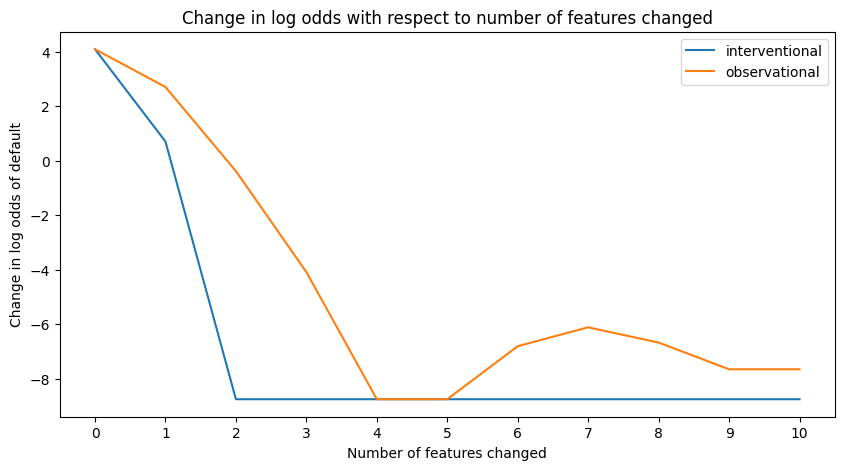

In [34]:
# logodds
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, 11), logodds_i, label='interventional')
plt.plot(np.arange(0, 11), logodds_c, label='observational')
plt.xlabel('Number of features changed')
plt.ylabel('Change in log odds of default')
plt.legend()
plt.xticks(np.arange(0, 11))
plt.title('Change in log odds with respect to number of features changed')
plt.show()

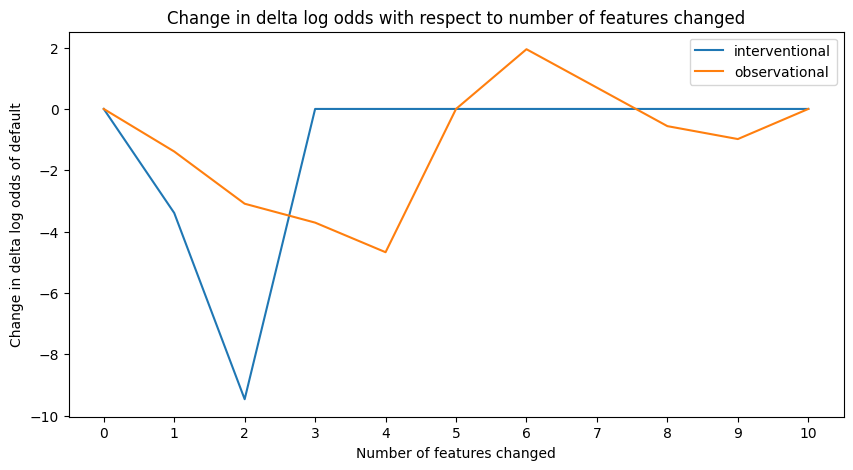

In [35]:
# delta logodds
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, 11), logodds_diff_i, label='interventional')
plt.plot(np.arange(0, 11), logodds_diff_c, label='observational')
plt.xlabel('Number of features changed')
plt.ylabel('Change in delta log odds of default')
plt.legend()
plt.xticks(np.arange(0, 11))
plt.title('Change in delta log odds with respect to number of features changed')
plt.show()

-> Interventional is better

### True to model

In [36]:
nhanes_m = nhanes.copy()

In [37]:
mcol=list(mort.columns)
mcol.remove('mortstat')
mcol

['ID',
 'eligstat',
 'ucod_leading',
 'diabetes',
 'hyperten',
 'permth_int',
 'permth_exm']

In [38]:
# remove cause of deaths
nhanes_m.drop(mcol, axis=1, inplace=True)

In [39]:
edu_map = {
    'Some College':2,
    'College Grad':2,
    'High School':1,
    '9 - 11th Grade':1,
    '8th Grade':0
}
nhanes_m.Education.replace(edu_map, inplace=True)
nhanes_m.Education.fillna(1, inplace=True) # Education is only participant who is 20 years or older

In [40]:
nhanes_m.Diabetes.replace({'Yes':1, 'No':0}, inplace=True)
nhanes_m.Diabetes.fillna(0, inplace=True)

In [41]:
nhanes_m.HealthGen.replace({'Excellent':2, 'Vgood':1, 'Good':0, 'Fair':-1, 'Poor':-2}, inplace=True)
nhanes_m.HealthGen.fillna(0, inplace=True)

In [42]:
dep_map = {
    'None': 0,
    'Several': 1,
    'Most': 2
}
nhanes_m.LittleInterest.replace(dep_map, inplace=True)
nhanes_m.LittleInterest.fillna(0, inplace=True)
nhanes_m.Depressed.replace(dep_map, inplace=True)
nhanes_m.Depressed.fillna(0, inplace=True)

In [43]:
nhanes_m.SleepTrouble.replace({'Yes':1, 'No':0}, inplace=True)
nhanes_m.SleepTrouble.fillna(0, inplace=True)

nhanes_m.PhysActive.replace({'Yes':1, 'No':0}, inplace=True)
nhanes_m.PhysActive.fillna(0, inplace=True)

nhanes_m.Alcohol12PlusYr.replace({'Yes':1, 'No':0}, inplace=True)
nhanes_m.Alcohol12PlusYr.fillna(0, inplace=True)

nhanes_m.SmokeNow.replace({'Yes':1, 'No':0}, inplace=True)
nhanes_m.SmokeNow.fillna(0, inplace=True)

nhanes_m.Smoke100.replace({'Yes':1, 'No':0}, inplace=True)
nhanes_m.Smoke100.fillna(0, inplace=True)

nhanes_m.Marijuana.replace({'Yes':1, 'No':0}, inplace=True)
nhanes_m.Marijuana.fillna(0, inplace=True)

nhanes_m.RegularMarij.replace({'Yes':1, 'No':0}, inplace=True)
nhanes_m.RegularMarij.fillna(0, inplace=True)

nhanes_m.HardDrugs.replace({'Yes':1, 'No':0}, inplace=True)
nhanes_m.HardDrugs.fillna(0, inplace=True)

nhanes_m.SexEver.replace({'Yes':1, 'No':0}, inplace=True)
nhanes_m.SexEver.fillna(0, inplace=True)

nhanes_m.PregnantNow.replace({'Yes':1, 'No':0, 'Unknown':0}, inplace=True)
nhanes_m.PregnantNow.fillna(0, inplace=True)

In [44]:
# drop unnessary columns
dropcol=['SurveyYr', 'AgeMonths', 'Race3', 'TVHrsDay', 'HHIncome', 'BMICatUnder20yrs', 'BMI_WHO', 'CompHrsDay', 'SameSex', 'SexOrientation', 'PregnantNow']

In [45]:
# drop dropcol
nhanes_m.drop(dropcol, axis=1, inplace=True)

In [46]:
# show categorical cols
ccol=nhanes_m.select_dtypes(include=['object']).columns
# fillna with mode
for col in ccol:
    nhanes_m[col].fillna(nhanes_m[col].mode()[0], inplace=True)

In [47]:
# dummy variables for ccol
nhanes_m=pd.get_dummies(nhanes_m, columns=ccol, drop_first=True)

In [48]:
# fillnan with mean
nhanes_m.fillna(nhanes_m.mean(), inplace=True)

In [49]:
# drop row with all nan 
nhanes_m.dropna(axis=0, how='all', inplace=True)

In [50]:
nhanes_m.drop(['Length', 'HeadCirc'], axis=1, inplace=True) # ft for < 2 y.o

In [51]:
# drop column with more than 1k nan
nhanes_m.dropna(axis=1, thresh=1000, inplace=True)

In [52]:
# downsample to 1/2 * row
nhanes_ms=nhanes_m.sample(frac=0.5, random_state=123)

In [69]:
# train test split
X = nhanes_ms.drop('mortstat', axis=1)
y = nhanes_ms.mortstat
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# logistic regression
logreg = LogisticRegression(n_jobs=-1)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
# accuracy
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.86


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


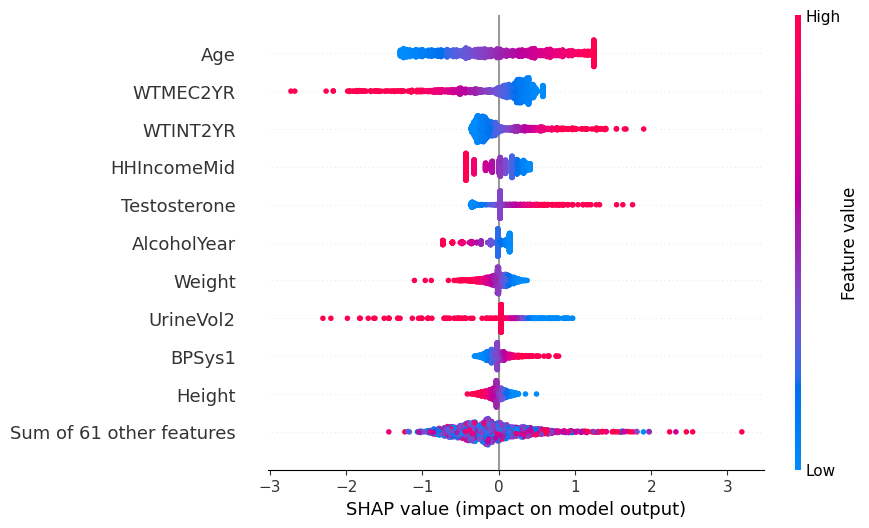

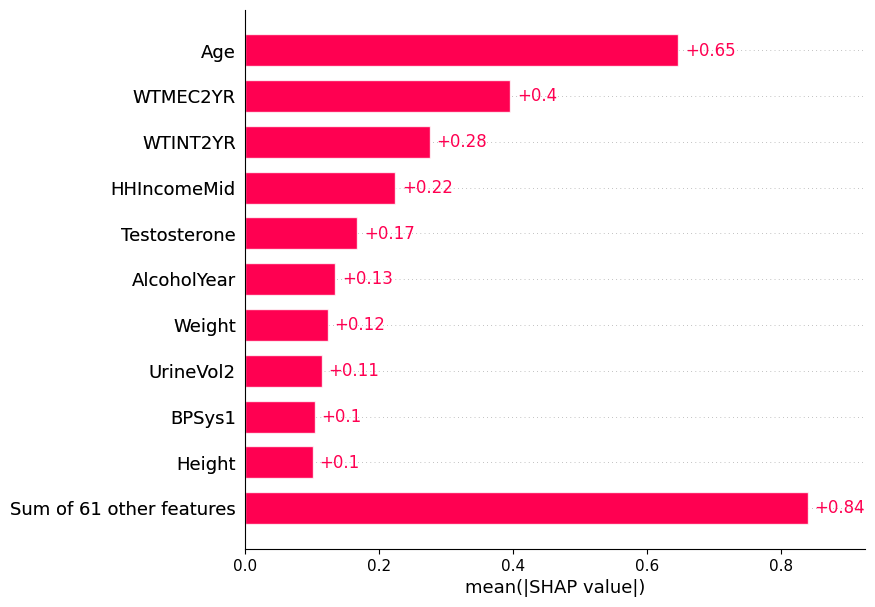

In [70]:
# Interventional
masker = shap.maskers.Independent(X_train)
explainer = shap.Explainer(logreg, masker)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values, max_display=11)
shap.plots.bar(shap_values, max_display=11)

In [71]:
# top 10 features
ft_id=np.argsort(np.mean(np.abs(shap_values.values), axis=0))[::-1][:10]
top10_ft_i=X_test.columns[ft_id]
top10_ft_i

Index(['Age', 'WTMEC2YR', 'WTINT2YR', 'HHIncomeMid', 'Testosterone',
       'AlcoholYear', 'Weight', 'UrineVol2', 'BPSys1', 'Height'],
      dtype='object')

In [72]:
ft_i_map = [1, 0, 1, 0, 1, 0, 0, 0, 1 ,0]
ft_i_dictm=dict(zip(top10_ft_i, ft_i_map))
ft_i_dictm

{'Age': 1,
 'WTMEC2YR': 0,
 'WTINT2YR': 1,
 'HHIncomeMid': 0,
 'Testosterone': 1,
 'AlcoholYear': 0,
 'Weight': 0,
 'UrineVol2': 0,
 'BPSys1': 1,
 'Height': 0}

Estimating transforms: 100%|██████████| 1000/1000 [00:09<00:00, 103.33it/s]
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


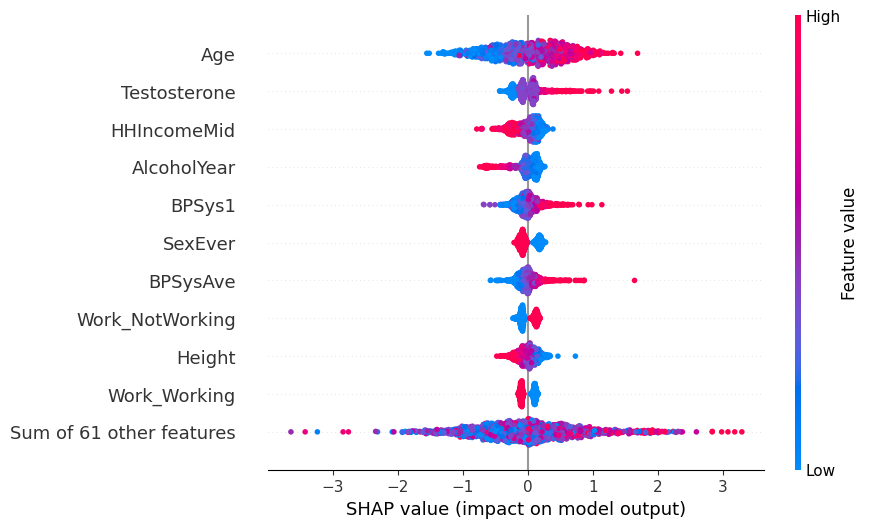

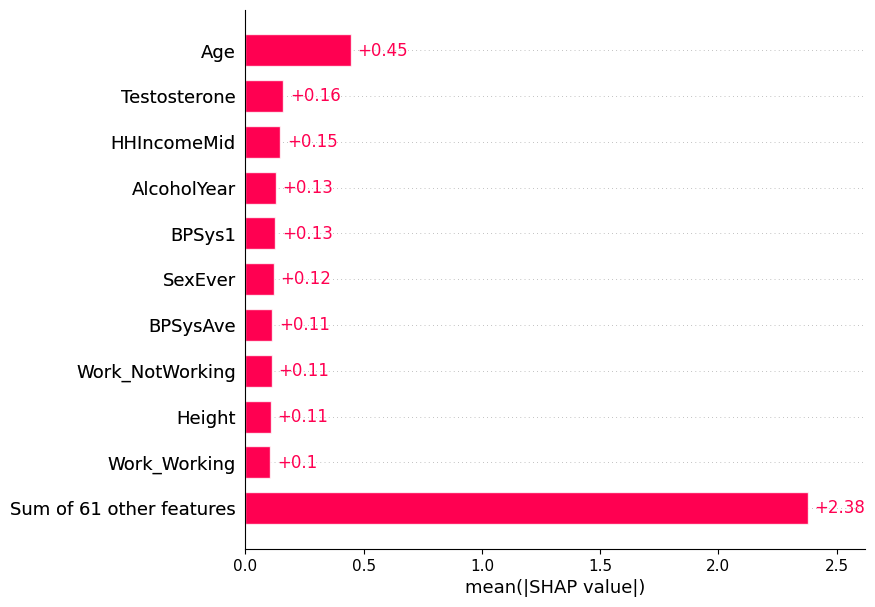

In [73]:
# Observational
masker = shap.maskers.Impute(X_train)
explainer = shap.Explainer(logreg, masker)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values, max_display=11)
shap.plots.bar(shap_values, max_display=11)

In [74]:
# top 10 features
ft_id=np.argsort(np.mean(np.abs(shap_values.values), axis=0))[::-1][:10]
top10_ft_c=X_test.columns[ft_id]
top10_ft_c

Index(['Age', 'Testosterone', 'HHIncomeMid', 'AlcoholYear', 'BPSys1',
       'SexEver', 'BPSysAve', 'Work_NotWorking', 'Height', 'Work_Working'],
      dtype='object')

In [75]:
ft_c_map = [1, 1, 0, 0, 0, 1, 1, 1, 1, 0]
ft_c_dictm=dict(zip(top10_ft_c, ft_c_map))
ft_c_dictm

{'Age': 1,
 'Testosterone': 1,
 'HHIncomeMid': 0,
 'AlcoholYear': 0,
 'BPSys1': 0,
 'SexEver': 1,
 'BPSysAve': 1,
 'Work_NotWorking': 1,
 'Height': 1,
 'Work_Working': 0}

In [78]:
print('1: Not default, 0: Default')
print('-----------------')
logodds_c, logodds_diff_c = logodds_default(X_test, logreg, ft_c_dictm)
logodds_i, logodds_diff_i = logodds_default(X_test, logreg, ft_i_dictm)

1: Not default, 0: Default
-----------------
0/1: 1132 / 104 -> logodds: 2.378663910870483
0/1: 345 / 891 -> logodds: -0.9470273575222851
0/1: 156 / 1080 -> logodds: -1.9293960122909002
0/1: 89 / 1147 -> logodds: -2.5459669065492467
0/1: 169 / 1067 -> logodds: -1.8377445824698784
0/1: 169 / 1067 -> logodds: -1.8377445824698784
0/1: 28 / 1208 -> logodds: -3.7302530206283184
0/1: 28 / 1208 -> logodds: -3.7302530206283184
0/1: 60 / 1176 -> logodds: -2.9598502430869655
0/1: 59 / 1177 -> logodds: -2.977228801989431
-----------------
0/1: 1132 / 104 -> logodds: 2.378663910870483
0/1: 1015 / 221 -> logodds: 1.5209512462661479
0/1: 85 / 1151 -> logodds: -2.5949075450023287
0/1: 19 / 1217 -> logodds: -4.109233174715851
0/1: 0 / 1236 -> logodds: -7.1204443723924875
0/1: 0 / 1236 -> logodds: -7.1204443723924875
0/1: 0 / 1236 -> logodds: -7.1204443723924875
0/1: 0 / 1236 -> logodds: -7.1204443723924875
0/1: 0 / 1236 -> logodds: -7.1204443723924875
0/1: 0 / 1236 -> logodds: -7.1204443723924875
----

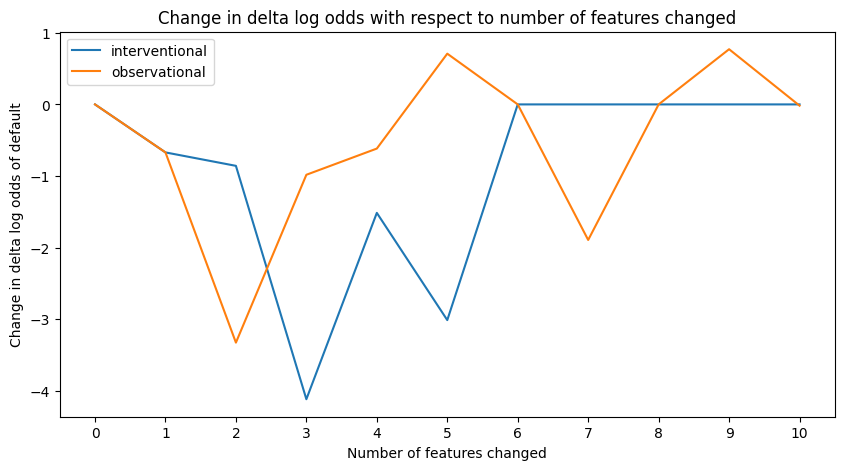

In [80]:
# delta logodds
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, 11), logodds_diff_i, label='interventional')
plt.plot(np.arange(0, 11), logodds_diff_c, label='observational')
plt.xlabel('Number of features changed')
plt.ylabel('Change in delta log odds of default')
plt.legend()
plt.xticks(np.arange(0, 11))
plt.title('Change in delta log odds with respect to number of features changed')
plt.show()

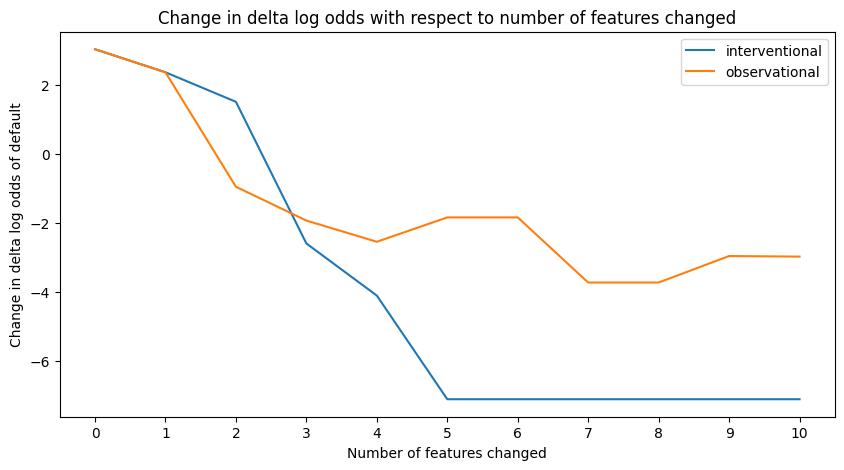

In [82]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, 11), logodds_i, label='interventional')
plt.plot(np.arange(0, 11), logodds_c, label='observational')
plt.xlabel('Number of features changed')
plt.ylabel('Change in delta log odds of default')
plt.legend()
plt.xticks(np.arange(0, 11))
plt.title('Change in delta log odds with respect to number of features changed')
plt.show()